# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Pau Argelaguet Franquelo"
student2 = "Natalie Bolon Brun"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(hash(student1 + student2) % 2**32)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('data/train_32x32.mat')
data_test = scipy.io.loadmat('data/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

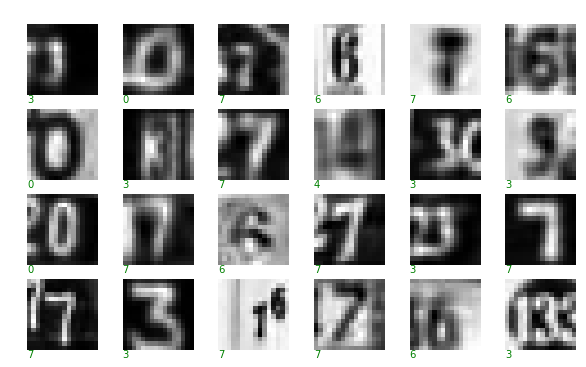

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [8]:
ex1_model = Sequential([
    Dense(5, input_shape=(256,), activation='softmax'),
])

ex1_model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ex1_history = ex1_model.fit(x_train, y_train, epochs=500, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 32225 samples, validate on 11145 samples
Epoch 1/500
32225/32225 [==============================] - 0s 13us/step - loss: 1.6112 - acc: 0.2274 - val_loss: 1.6164 - val_acc: 0.2386
Epoch 2/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.6026 - acc: 0.2454 - val_loss: 1.6084 - val_acc: 0.2408
Epoch 3/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5969 - acc: 0.2533 - val_loss: 1.6031 - val_acc: 0.2528
Epoch 4/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5921 - acc: 0.2618 - val_loss: 1.5990 - val_acc: 0.2579
Epoch 5/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5881 - acc: 0.2678 - val_loss: 1.5958 - val_acc: 0.2616
Epoch 6/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5847 - acc: 0.2721 - val_loss: 1.5915 - val_acc: 0.2670
Epoch 7/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5818 - acc: 0.2770 - val_loss: 1.5888 - 

32225/32225 [==============================] - 0s 11us/step - loss: 1.5416 - acc: 0.3312 - val_loss: 1.5705 - val_acc: 0.3142
Epoch 60/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5414 - acc: 0.3331 - val_loss: 1.5708 - val_acc: 0.3123
Epoch 61/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5411 - acc: 0.3330 - val_loss: 1.5708 - val_acc: 0.3155
Epoch 62/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5408 - acc: 0.3341 - val_loss: 1.5716 - val_acc: 0.3098
Epoch 63/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5404 - acc: 0.3324 - val_loss: 1.5709 - val_acc: 0.3167
Epoch 64/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5402 - acc: 0.3337 - val_loss: 1.5708 - val_acc: 0.3201
Epoch 65/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5400 - acc: 0.3335 - val_loss: 1.5712 - val_acc: 0.3143
Epoch 66/500
32225/32225 [==============

Epoch 118/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5307 - acc: 0.3425 - val_loss: 1.5758 - val_acc: 0.3205
Epoch 119/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5307 - acc: 0.3439 - val_loss: 1.5761 - val_acc: 0.3183
Epoch 120/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5306 - acc: 0.3451 - val_loss: 1.5763 - val_acc: 0.3180
Epoch 121/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5305 - acc: 0.3447 - val_loss: 1.5764 - val_acc: 0.3179
Epoch 122/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5303 - acc: 0.3445 - val_loss: 1.5762 - val_acc: 0.3199
Epoch 123/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5302 - acc: 0.3447 - val_loss: 1.5765 - val_acc: 0.3170
Epoch 124/500
32225/32225 [==============================] - 1s 18us/step - loss: 1.5301 - acc: 0.3444 - val_loss: 1.5768 - val_acc: 0.3178
Epoch 125/500
32225/

32225/32225 [==============================] - 0s 11us/step - loss: 1.5257 - acc: 0.3494 - val_loss: 1.5804 - val_acc: 0.3173
Epoch 177/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5256 - acc: 0.3492 - val_loss: 1.5806 - val_acc: 0.3207
Epoch 178/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5255 - acc: 0.3495 - val_loss: 1.5807 - val_acc: 0.3193
Epoch 179/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5255 - acc: 0.3487 - val_loss: 1.5805 - val_acc: 0.3189
Epoch 180/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5254 - acc: 0.3487 - val_loss: 1.5805 - val_acc: 0.3227
Epoch 181/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5254 - acc: 0.3498 - val_loss: 1.5807 - val_acc: 0.3202
Epoch 182/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5252 - acc: 0.3492 - val_loss: 1.5811 - val_acc: 0.3177
Epoch 183/500
32225/32225 [=======

32225/32225 [==============================] - 0s 11us/step - loss: 1.5226 - acc: 0.3520 - val_loss: 1.5836 - val_acc: 0.3189
Epoch 235/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5224 - acc: 0.3531 - val_loss: 1.5840 - val_acc: 0.3166
Epoch 236/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5225 - acc: 0.3519 - val_loss: 1.5837 - val_acc: 0.3213
Epoch 237/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5225 - acc: 0.3521 - val_loss: 1.5838 - val_acc: 0.3193
Epoch 238/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5224 - acc: 0.3524 - val_loss: 1.5839 - val_acc: 0.3209
Epoch 239/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5224 - acc: 0.3512 - val_loss: 1.5838 - val_acc: 0.3210
Epoch 240/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5223 - acc: 0.3522 - val_loss: 1.5840 - val_acc: 0.3212
Epoch 241/500
32225/32225 [=======

32225/32225 [==============================] - 0s 11us/step - loss: 1.5205 - acc: 0.3548 - val_loss: 1.5861 - val_acc: 0.3209
Epoch 293/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5204 - acc: 0.3546 - val_loss: 1.5857 - val_acc: 0.3221
Epoch 294/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5203 - acc: 0.3546 - val_loss: 1.5861 - val_acc: 0.3196
Epoch 295/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5203 - acc: 0.3550 - val_loss: 1.5862 - val_acc: 0.3173
Epoch 296/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5203 - acc: 0.3547 - val_loss: 1.5859 - val_acc: 0.3222
Epoch 297/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5202 - acc: 0.3552 - val_loss: 1.5860 - val_acc: 0.3204
Epoch 298/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5203 - acc: 0.3548 - val_loss: 1.5861 - val_acc: 0.3192
Epoch 299/500
32225/32225 [=======

32225/32225 [==============================] - 0s 12us/step - loss: 1.5187 - acc: 0.3559 - val_loss: 1.5879 - val_acc: 0.3171
Epoch 351/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5187 - acc: 0.3562 - val_loss: 1.5881 - val_acc: 0.3189
Epoch 352/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5187 - acc: 0.3567 - val_loss: 1.5875 - val_acc: 0.3185
Epoch 353/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5186 - acc: 0.3577 - val_loss: 1.5880 - val_acc: 0.3201
Epoch 354/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5187 - acc: 0.3563 - val_loss: 1.5880 - val_acc: 0.3191
Epoch 355/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5187 - acc: 0.3575 - val_loss: 1.5882 - val_acc: 0.3159
Epoch 356/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5186 - acc: 0.3548 - val_loss: 1.5878 - val_acc: 0.3186
Epoch 357/500
32225/32225 [=======

32225/32225 [==============================] - 0s 11us/step - loss: 1.5175 - acc: 0.3583 - val_loss: 1.5890 - val_acc: 0.3183
Epoch 409/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5175 - acc: 0.3582 - val_loss: 1.5890 - val_acc: 0.3199
Epoch 410/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5173 - acc: 0.3578 - val_loss: 1.5889 - val_acc: 0.3208
Epoch 411/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5174 - acc: 0.3579 - val_loss: 1.5889 - val_acc: 0.3201
Epoch 412/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5174 - acc: 0.3589 - val_loss: 1.5890 - val_acc: 0.3205
Epoch 413/500
32225/32225 [==============================] - 0s 12us/step - loss: 1.5174 - acc: 0.3577 - val_loss: 1.5889 - val_acc: 0.3199
Epoch 414/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5173 - acc: 0.3586 - val_loss: 1.5889 - val_acc: 0.3193
Epoch 415/500
32225/32225 [=======

32225/32225 [==============================] - 0s 11us/step - loss: 1.5163 - acc: 0.3578 - val_loss: 1.5899 - val_acc: 0.3202
Epoch 467/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5163 - acc: 0.3604 - val_loss: 1.5900 - val_acc: 0.3190
Epoch 468/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5163 - acc: 0.3594 - val_loss: 1.5901 - val_acc: 0.3185
Epoch 469/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5163 - acc: 0.3589 - val_loss: 1.5900 - val_acc: 0.3193
Epoch 470/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5161 - acc: 0.3595 - val_loss: 1.5901 - val_acc: 0.3198
Epoch 471/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5163 - acc: 0.3604 - val_loss: 1.5903 - val_acc: 0.3191
Epoch 472/500
32225/32225 [==============================] - 0s 11us/step - loss: 1.5163 - acc: 0.3589 - val_loss: 1.5901 - val_acc: 0.3192
Epoch 473/500
32225/32225 [=======

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________


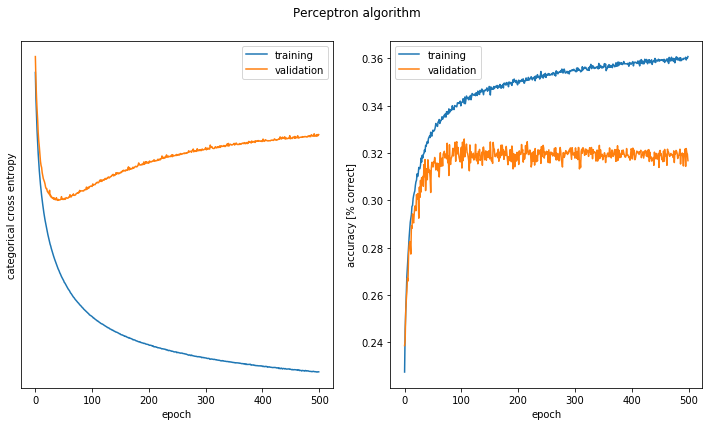

Test loss: 1.59091962966
Test accuracy: 0.316733961426


In [9]:
ex1_model.summary()
plot_history(ex1_history, "Perceptron algorithm")
plt.show()

score = ex1_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

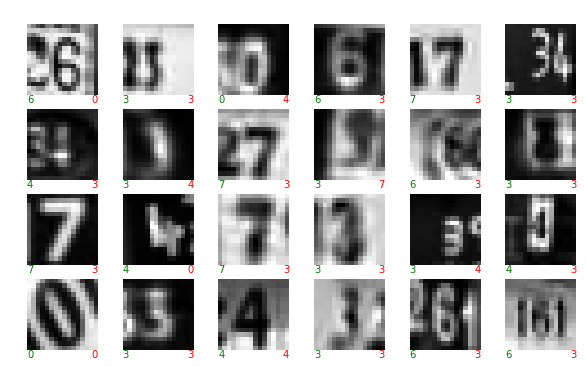

In [10]:
yhat_test = ex1_model.predict_on_batch(x_test)
error = np.linalg.norm(((yhat_test.round()) - y_test),axis=1)
error_indices = np.nonzero(error)[0]

plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)
plt.show()

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [11]:
ex2_model_sgd = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_sgd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [12]:
lrates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5]
histories = []
for lrate in lrates:
    ex2_model_sgd.compile(optimizer=SGD(lr=lrate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    histories.append(ex2_model_sgd.fit(x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1))

Train on 32225 samples, validate on 11145 samples
Epoch 1/50
32225/32225 [==============================] - 1s 17us/step - loss: 1.6099 - acc: 0.2326 - val_loss: 1.6112 - val_acc: 0.2362
Epoch 2/50
32225/32225 [==============================] - 1s 24us/step - loss: 1.6039 - acc: 0.2480 - val_loss: 1.6098 - val_acc: 0.2440
Epoch 3/50
32225/32225 [==============================] - 0s 15us/step - loss: 1.6021 - acc: 0.2533 - val_loss: 1.6084 - val_acc: 0.2453
Epoch 4/50
32225/32225 [==============================] - 0s 15us/step - loss: 1.6006 - acc: 0.2557 - val_loss: 1.6070 - val_acc: 0.2473
Epoch 5/50
32225/32225 [==============================] - 1s 19us/step - loss: 1.5992 - acc: 0.2579 - val_loss: 1.6054 - val_acc: 0.2476
Epoch 6/50
32225/32225 [==============================] - 1s 16us/step - loss: 1.5978 - acc: 0.2596 - val_loss: 1.6039 - val_acc: 0.2485
Epoch 7/50
32225/32225 [==============================] - 0s 15us/step - loss: 1.5966 - acc: 0.2621 - val_loss: 1.6027 - val_acc

Epoch 10/50
32225/32225 [==============================] - 1s 17us/step - loss: 1.5071 - acc: 0.3789 - val_loss: 1.5041 - val_acc: 0.3751
Epoch 11/50
32225/32225 [==============================] - 1s 17us/step - loss: 1.5001 - acc: 0.3868 - val_loss: 1.4965 - val_acc: 0.3788
Epoch 12/50
32225/32225 [==============================] - 1s 17us/step - loss: 1.4928 - acc: 0.3931 - val_loss: 1.4894 - val_acc: 0.3830
Epoch 13/50
32225/32225 [==============================] - 1s 16us/step - loss: 1.4853 - acc: 0.3987 - val_loss: 1.4816 - val_acc: 0.3897
Epoch 14/50
32225/32225 [==============================] - 1s 16us/step - loss: 1.4776 - acc: 0.4052 - val_loss: 1.4740 - val_acc: 0.3949
Epoch 15/50
32225/32225 [==============================] - 1s 16us/step - loss: 1.4696 - acc: 0.4096 - val_loss: 1.4656 - val_acc: 0.4015
Epoch 16/50
32225/32225 [==============================] - 1s 16us/step - loss: 1.4613 - acc: 0.4158 - val_loss: 1.4572 - val_acc: 0.4059
Epoch 17/50
32225/32225 [=========

32225/32225 [==============================] - 1s 28us/step - loss: 0.8869 - acc: 0.7289 - val_loss: 0.9286 - val_acc: 0.6944
Epoch 20/50
32225/32225 [==============================] - 1s 29us/step - loss: 0.8788 - acc: 0.7326 - val_loss: 0.9206 - val_acc: 0.6939
Epoch 21/50
32225/32225 [==============================] - 1s 26us/step - loss: 0.8705 - acc: 0.7355 - val_loss: 0.9175 - val_acc: 0.6988
Epoch 22/50
32225/32225 [==============================] - 1s 32us/step - loss: 0.8632 - acc: 0.7386 - val_loss: 0.9057 - val_acc: 0.7017
Epoch 23/50
32225/32225 [==============================] - 1s 23us/step - loss: 0.8559 - acc: 0.7398 - val_loss: 0.9031 - val_acc: 0.7048
Epoch 24/50
32225/32225 [==============================] - 1s 24us/step - loss: 0.8486 - acc: 0.7439 - val_loss: 0.8983 - val_acc: 0.7050
Epoch 25/50
32225/32225 [==============================] - 1s 24us/step - loss: 0.8419 - acc: 0.7472 - val_loss: 0.8921 - val_acc: 0.7060
Epoch 26/50
32225/32225 [=====================

32225/32225 [==============================] - 0s 15us/step - loss: 0.5403 - acc: 0.8368 - val_loss: 0.6805 - val_acc: 0.7912
Epoch 29/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.5348 - acc: 0.8385 - val_loss: 0.7109 - val_acc: 0.7836
Epoch 30/50
32225/32225 [==============================] - 0s 15us/step - loss: 0.5316 - acc: 0.8391 - val_loss: 0.6718 - val_acc: 0.7946
Epoch 31/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.5266 - acc: 0.8401 - val_loss: 0.6712 - val_acc: 0.7969
Epoch 32/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.5243 - acc: 0.8420 - val_loss: 0.6657 - val_acc: 0.7952
Epoch 33/50
32225/32225 [==============================] - 0s 16us/step - loss: 0.5187 - acc: 0.8430 - val_loss: 0.6622 - val_acc: 0.7994
Epoch 34/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.5156 - acc: 0.8437 - val_loss: 0.6630 - val_acc: 0.7999
Epoch 35/50
32225/32225 [=====================

32225/32225 [==============================] - 0s 15us/step - loss: 0.3554 - acc: 0.8940 - val_loss: 0.5498 - val_acc: 0.8539
Epoch 38/50
32225/32225 [==============================] - 1s 25us/step - loss: 0.3571 - acc: 0.8917 - val_loss: 0.5369 - val_acc: 0.8558
Epoch 39/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.3505 - acc: 0.8955 - val_loss: 0.5616 - val_acc: 0.8481
Epoch 40/50
32225/32225 [==============================] - 1s 17us/step - loss: 0.3511 - acc: 0.8944 - val_loss: 0.5266 - val_acc: 0.8587
Epoch 41/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.3472 - acc: 0.8970 - val_loss: 0.5298 - val_acc: 0.8545
Epoch 42/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.3481 - acc: 0.8946 - val_loss: 0.5299 - val_acc: 0.8593
Epoch 43/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.3433 - acc: 0.8972 - val_loss: 0.5239 - val_acc: 0.8629
Epoch 44/50
32225/32225 [=====================

32225/32225 [==============================] - 1s 16us/step - loss: 0.3461 - acc: 0.8908 - val_loss: 0.6084 - val_acc: 0.8445
Epoch 47/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.3486 - acc: 0.8925 - val_loss: 0.5605 - val_acc: 0.8616
Epoch 48/50
32225/32225 [==============================] - 1s 40us/step - loss: 0.3357 - acc: 0.8946 - val_loss: 0.5632 - val_acc: 0.8600
Epoch 49/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.3476 - acc: 0.8920 - val_loss: 0.5639 - val_acc: 0.8589
Epoch 50/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.3352 - acc: 0.8950 - val_loss: 0.5711 - val_acc: 0.8626
Train on 32225 samples, validate on 11145 samples
Epoch 1/50
32225/32225 [==============================] - 1s 20us/step - loss: 0.8458 - acc: 0.7290 - val_loss: 0.7581 - val_acc: 0.7694
Epoch 2/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.6608 - acc: 0.7863 - val_loss: 1.0987 - val_acc: 0.612

Epoch 5/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.7850 - acc: 0.7288 - val_loss: 1.0698 - val_acc: 0.6703
Epoch 6/50
32225/32225 [==============================] - 0s 16us/step - loss: 0.7799 - acc: 0.7289 - val_loss: 1.0425 - val_acc: 0.6894
Epoch 7/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.7325 - acc: 0.7496 - val_loss: 0.9186 - val_acc: 0.7323
Epoch 8/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.6604 - acc: 0.7811 - val_loss: 1.1261 - val_acc: 0.6993
Epoch 9/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.6666 - acc: 0.7788 - val_loss: 0.8876 - val_acc: 0.7339
Epoch 10/50
32225/32225 [==============================] - 0s 15us/step - loss: 0.7488 - acc: 0.7541 - val_loss: 0.9567 - val_acc: 0.7185
Epoch 11/50
32225/32225 [==============================] - 1s 16us/step - loss: 0.7143 - acc: 0.7574 - val_loss: 0.8182 - val_acc: 0.7663
Epoch 12/50
32225/32225 [==============

32225/32225 [==============================] - 1s 17us/step - loss: 1.3211 - acc: 0.4050 - val_loss: 1.4338 - val_acc: 0.4035
Epoch 15/50
32225/32225 [==============================] - 1s 17us/step - loss: 1.3193 - acc: 0.4040 - val_loss: 1.4773 - val_acc: 0.4054
Epoch 16/50
32225/32225 [==============================] - 1s 17us/step - loss: 1.2937 - acc: 0.4169 - val_loss: 1.4057 - val_acc: 0.4296
Epoch 17/50
32225/32225 [==============================] - 1s 17us/step - loss: 1.2445 - acc: 0.4485 - val_loss: 1.3488 - val_acc: 0.4469
Epoch 18/50
32225/32225 [==============================] - 1s 17us/step - loss: 1.2412 - acc: 0.4533 - val_loss: 1.3641 - val_acc: 0.4138
Epoch 19/50
32225/32225 [==============================] - 1s 17us/step - loss: 1.2444 - acc: 0.4503 - val_loss: 1.3945 - val_acc: 0.4484
Epoch 20/50
32225/32225 [==============================] - 1s 16us/step - loss: 1.2465 - acc: 0.4523 - val_loss: 1.4010 - val_acc: 0.4424
Epoch 21/50
32225/32225 [=====================

In [13]:
for lr, h in zip(lrates, histories):
    print("Loss for lr {}: {}".format(lr, h.history.get('loss')[-1]))

Loss for lr 0.001: 1.5590177450779337
Loss for lr 0.005: 1.1302871742241136
Loss for lr 0.01: 0.7291368848506197
Loss for lr 0.05: 0.4641888351936133
Loss for lr 0.1: 0.32934954514514575
Loss for lr 0.5: 0.33515877635558505
Loss for lr 1: 0.34235148431442797
Loss for lr 2: 0.7042351054608869
Loss for lr 5: 1.2607027201545247


In [14]:
ex2_model_ada = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_ada.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [15]:
ex2_model_ada.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

adam_history = ex2_model_ada.fit(x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 32225 samples, validate on 11145 samples
Epoch 1/50
32225/32225 [==============================] - 1s 24us/step - loss: 1.4572 - acc: 0.4381 - val_loss: 1.2418 - val_acc: 0.5891
Epoch 2/50
32225/32225 [==============================] - 1s 17us/step - loss: 1.0773 - acc: 0.6723 - val_loss: 0.9728 - val_acc: 0.6813
Epoch 3/50
32225/32225 [==============================] - 1s 17us/step - loss: 0.8706 - acc: 0.7422 - val_loss: 0.8658 - val_acc: 0.7265
Epoch 4/50
32225/32225 [==============================] - 1s 18us/step - loss: 0.7777 - acc: 0.7702 - val_loss: 0.8238 - val_acc: 0.7455
Epoch 5/50
32225/32225 [==============================] - 1s 17us/step - loss: 0.7236 - acc: 0.7832 - val_loss: 0.8083 - val_acc: 0.7461
Epoch 6/50
32225/32225 [==============================] - 1s 18us/step - loss: 0.6888 - acc: 0.7929 - val_loss: 0.7709 - val_acc: 0.7593
Epoch 7/50
32225/32225 [==============================] - 1s 18us/step - loss: 0.6619 - acc: 0.7988 - val_loss: 0.7584 - val_acc

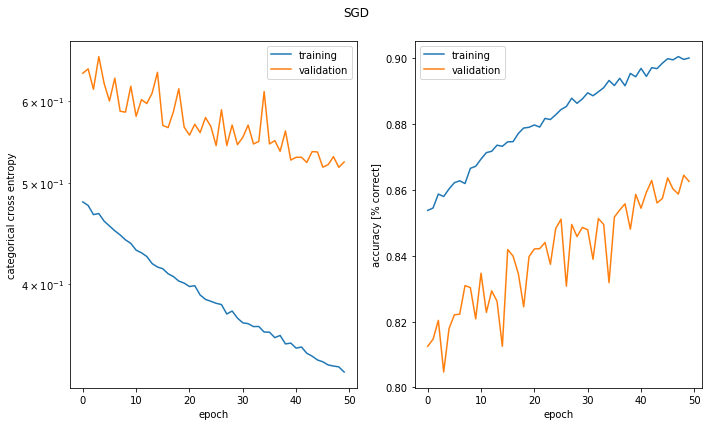

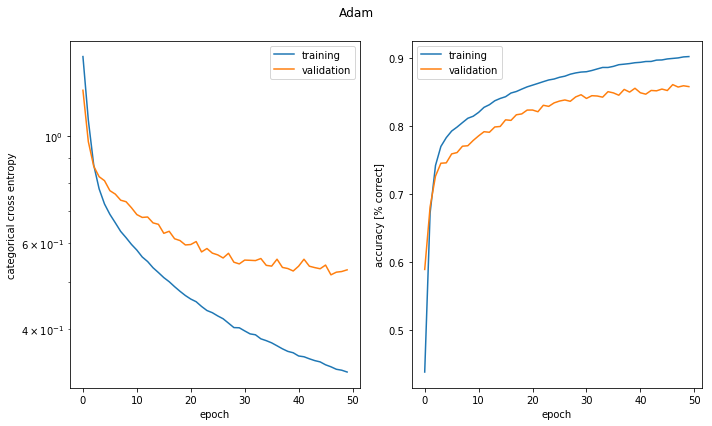

In [16]:
# histories[4] is the one that has smallest loss
plot_history(histories[4], "SGD")
plot_history(adam_history, "Adam")
plt.show()

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) If the learning rate is too large, the solucion may oscillate around a value and never achieve a minimum. It may even lead to increasing error during the training period obtening very poor results

B) If the learning rate is too small, the improvement per epoch may be too small too and so, the number of epochs needed to achieve a reasonable results may be extremly large. 

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [17]:
ex3_model = Sequential([
    Dense(64, input_shape=(256,), activation="relu"),
    Dense(5, activation="softmax"),
])

ex3_model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

adam_history = ex3_model.fit(x_train, y_train, epochs=1000, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 32225 samples, validate on 11145 samples
Epoch 1/1000
32225/32225 [==============================] - 1s 27us/step - loss: 1.4422 - acc: 0.4350 - val_loss: 1.1991 - val_acc: 0.5978
Epoch 2/1000
32225/32225 [==============================] - 1s 17us/step - loss: 1.0475 - acc: 0.6811 - val_loss: 0.9464 - val_acc: 0.6891
Epoch 3/1000
32225/32225 [==============================] - 1s 28us/step - loss: 0.8513 - acc: 0.7500 - val_loss: 0.8481 - val_acc: 0.7377
Epoch 4/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.7609 - acc: 0.7749 - val_loss: 0.8103 - val_acc: 0.7444
Epoch 5/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.7126 - acc: 0.7872 - val_loss: 0.7787 - val_acc: 0.7602
Epoch 6/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.6729 - acc: 0.7975 - val_loss: 0.7511 - val_acc: 0.7647
Epoch 7/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.6471 - acc: 0.8023 - val_loss: 0.

32225/32225 [==============================] - 1s 18us/step - loss: 0.3047 - acc: 0.9085 - val_loss: 0.5053 - val_acc: 0.8695
Epoch 60/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.3005 - acc: 0.9100 - val_loss: 0.5084 - val_acc: 0.8675
Epoch 61/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.2987 - acc: 0.9113 - val_loss: 0.5104 - val_acc: 0.8665
Epoch 62/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.2990 - acc: 0.9115 - val_loss: 0.5090 - val_acc: 0.8687
Epoch 63/1000
32225/32225 [==============================] - 2s 49us/step - loss: 0.2998 - acc: 0.9097 - val_loss: 0.5126 - val_acc: 0.8666
Epoch 64/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.2948 - acc: 0.9122 - val_loss: 0.5130 - val_acc: 0.8664
Epoch 65/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.2930 - acc: 0.9126 - val_loss: 0.5064 - val_acc: 0.8719
Epoch 66/1000
32225/32225 [=======

32225/32225 [==============================] - 1s 20us/step - loss: 0.2233 - acc: 0.9324 - val_loss: 0.5241 - val_acc: 0.8759
Epoch 118/1000
32225/32225 [==============================] - 1s 25us/step - loss: 0.2252 - acc: 0.9311 - val_loss: 0.5195 - val_acc: 0.8760
Epoch 119/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.2214 - acc: 0.9328 - val_loss: 0.5100 - val_acc: 0.8811
Epoch 120/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.2224 - acc: 0.9324 - val_loss: 0.5340 - val_acc: 0.8768
Epoch 121/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.2202 - acc: 0.9322 - val_loss: 0.5273 - val_acc: 0.8776
Epoch 122/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.2196 - acc: 0.9324 - val_loss: 0.5185 - val_acc: 0.8799
Epoch 123/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.2226 - acc: 0.9335 - val_loss: 0.5253 - val_acc: 0.8796
Epoch 124/1000
32225/32225 [

32225/32225 [==============================] - 1s 19us/step - loss: 0.1839 - acc: 0.9435 - val_loss: 0.5420 - val_acc: 0.8845
Epoch 176/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.1865 - acc: 0.9431 - val_loss: 0.5593 - val_acc: 0.8800
Epoch 177/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.1845 - acc: 0.9426 - val_loss: 0.5407 - val_acc: 0.8834
Epoch 178/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1822 - acc: 0.9434 - val_loss: 0.5481 - val_acc: 0.8805
Epoch 179/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1810 - acc: 0.9445 - val_loss: 0.5542 - val_acc: 0.8786
Epoch 180/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1891 - acc: 0.9417 - val_loss: 0.5497 - val_acc: 0.8826
Epoch 181/1000
32225/32225 [==============================] - 2s 49us/step - loss: 0.1819 - acc: 0.9441 - val_loss: 0.5520 - val_acc: 0.8796
Epoch 182/1000
32225/32225 [

32225/32225 [==============================] - 1s 31us/step - loss: 0.1601 - acc: 0.9501 - val_loss: 0.5823 - val_acc: 0.8791
Epoch 234/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1622 - acc: 0.9497 - val_loss: 0.5936 - val_acc: 0.8794
Epoch 235/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1616 - acc: 0.9507 - val_loss: 0.5729 - val_acc: 0.8834
Epoch 236/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1599 - acc: 0.9494 - val_loss: 0.5911 - val_acc: 0.8776
Epoch 237/1000
32225/32225 [==============================] - 1s 28us/step - loss: 0.1578 - acc: 0.9514 - val_loss: 0.5739 - val_acc: 0.8810
Epoch 238/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.1612 - acc: 0.9495 - val_loss: 0.5903 - val_acc: 0.8794
Epoch 239/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.1554 - acc: 0.9523 - val_loss: 0.5717 - val_acc: 0.8827
Epoch 240/1000
32225/32225 [

32225/32225 [==============================] - 1s 18us/step - loss: 0.1411 - acc: 0.9573 - val_loss: 0.6056 - val_acc: 0.8825
Epoch 292/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1436 - acc: 0.9562 - val_loss: 0.6022 - val_acc: 0.8834
Epoch 293/1000
32225/32225 [==============================] - 1s 21us/step - loss: 0.1449 - acc: 0.9556 - val_loss: 0.6153 - val_acc: 0.8816
Epoch 294/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1426 - acc: 0.9560 - val_loss: 0.6220 - val_acc: 0.8818
Epoch 295/1000
32225/32225 [==============================] - 1s 25us/step - loss: 0.1423 - acc: 0.9567 - val_loss: 0.6284 - val_acc: 0.8797
Epoch 296/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1428 - acc: 0.9552 - val_loss: 0.6020 - val_acc: 0.8829
Epoch 297/1000
32225/32225 [==============================] - 1s 30us/step - loss: 0.1455 - acc: 0.9551 - val_loss: 0.6257 - val_acc: 0.8817
Epoch 298/1000
32225/32225 [

32225/32225 [==============================] - 1s 24us/step - loss: 0.1315 - acc: 0.9588 - val_loss: 0.6319 - val_acc: 0.8834
Epoch 350/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.1318 - acc: 0.9595 - val_loss: 0.6329 - val_acc: 0.8854
Epoch 351/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1348 - acc: 0.9582 - val_loss: 0.6379 - val_acc: 0.8828
Epoch 352/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1312 - acc: 0.9594 - val_loss: 0.6431 - val_acc: 0.8825
Epoch 353/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1341 - acc: 0.9574 - val_loss: 0.6405 - val_acc: 0.8840
Epoch 354/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1281 - acc: 0.9596 - val_loss: 0.6407 - val_acc: 0.8827
Epoch 355/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.1279 - acc: 0.9606 - val_loss: 0.6286 - val_acc: 0.8836
Epoch 356/1000
32225/32225 [

32225/32225 [==============================] - 1s 20us/step - loss: 0.1218 - acc: 0.9633 - val_loss: 0.6657 - val_acc: 0.8825
Epoch 408/1000
32225/32225 [==============================] - 1s 23us/step - loss: 0.1211 - acc: 0.9623 - val_loss: 0.6604 - val_acc: 0.8842
Epoch 409/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1217 - acc: 0.9614 - val_loss: 0.6646 - val_acc: 0.8788
Epoch 410/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1188 - acc: 0.9627 - val_loss: 0.6950 - val_acc: 0.8762
Epoch 411/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.1190 - acc: 0.9630 - val_loss: 0.6678 - val_acc: 0.8816
Epoch 412/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1200 - acc: 0.9635 - val_loss: 0.6503 - val_acc: 0.8850
Epoch 413/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.1188 - acc: 0.9638 - val_loss: 0.6614 - val_acc: 0.8851
Epoch 414/1000
32225/32225 [

32225/32225 [==============================] - 1s 18us/step - loss: 0.1100 - acc: 0.9659 - val_loss: 0.6881 - val_acc: 0.8807
Epoch 466/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1116 - acc: 0.9660 - val_loss: 0.6965 - val_acc: 0.8819
Epoch 467/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1104 - acc: 0.9669 - val_loss: 0.6851 - val_acc: 0.8821
Epoch 468/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1130 - acc: 0.9646 - val_loss: 0.6776 - val_acc: 0.8841
Epoch 469/1000
32225/32225 [==============================] - 1s 40us/step - loss: 0.1136 - acc: 0.9651 - val_loss: 0.6849 - val_acc: 0.8827
Epoch 470/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1139 - acc: 0.9647 - val_loss: 0.6950 - val_acc: 0.8823
Epoch 471/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1114 - acc: 0.9655 - val_loss: 0.6833 - val_acc: 0.8825
Epoch 472/1000
32225/32225 [

32225/32225 [==============================] - 1s 18us/step - loss: 0.1011 - acc: 0.9681 - val_loss: 0.7157 - val_acc: 0.8829
Epoch 524/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1054 - acc: 0.9680 - val_loss: 0.6992 - val_acc: 0.8825
Epoch 525/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1024 - acc: 0.9686 - val_loss: 0.7381 - val_acc: 0.8790
Epoch 526/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1032 - acc: 0.9683 - val_loss: 0.7064 - val_acc: 0.8831
Epoch 527/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.1022 - acc: 0.9684 - val_loss: 0.7055 - val_acc: 0.8811
Epoch 528/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1023 - acc: 0.9680 - val_loss: 0.7139 - val_acc: 0.8799
Epoch 529/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0986 - acc: 0.9697 - val_loss: 0.7427 - val_acc: 0.8775
Epoch 530/1000
32225/32225 [

32225/32225 [==============================] - 1s 20us/step - loss: 0.0961 - acc: 0.9704 - val_loss: 0.7367 - val_acc: 0.8817
Epoch 582/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0938 - acc: 0.9719 - val_loss: 0.7157 - val_acc: 0.8819
Epoch 583/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1044 - acc: 0.9677 - val_loss: 0.7374 - val_acc: 0.8834
Epoch 584/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.1000 - acc: 0.9695 - val_loss: 0.7308 - val_acc: 0.8832
Epoch 585/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.1001 - acc: 0.9691 - val_loss: 0.7299 - val_acc: 0.8844
Epoch 586/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0917 - acc: 0.9732 - val_loss: 0.7261 - val_acc: 0.8822
Epoch 587/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0969 - acc: 0.9694 - val_loss: 0.7278 - val_acc: 0.8836
Epoch 588/1000
32225/32225 [

32225/32225 [==============================] - 2s 49us/step - loss: 0.0913 - acc: 0.9714 - val_loss: 0.7580 - val_acc: 0.8815
Epoch 640/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0914 - acc: 0.9718 - val_loss: 0.7579 - val_acc: 0.8813
Epoch 641/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0916 - acc: 0.9717 - val_loss: 0.7527 - val_acc: 0.8805
Epoch 642/1000
32225/32225 [==============================] - 1s 46us/step - loss: 0.0924 - acc: 0.9718 - val_loss: 0.7655 - val_acc: 0.8797
Epoch 643/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0896 - acc: 0.9742 - val_loss: 0.7494 - val_acc: 0.8816
Epoch 644/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0872 - acc: 0.9735 - val_loss: 0.7570 - val_acc: 0.8826
Epoch 645/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0854 - acc: 0.9740 - val_loss: 0.7664 - val_acc: 0.8804
Epoch 646/1000
32225/32225 [

32225/32225 [==============================] - 1s 17us/step - loss: 0.0896 - acc: 0.9719 - val_loss: 0.7764 - val_acc: 0.8800
Epoch 698/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0858 - acc: 0.9739 - val_loss: 0.7968 - val_acc: 0.8782
Epoch 699/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0895 - acc: 0.9723 - val_loss: 0.8075 - val_acc: 0.8775
Epoch 700/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0860 - acc: 0.9736 - val_loss: 0.7782 - val_acc: 0.8825
Epoch 701/1000
32225/32225 [==============================] - 1s 31us/step - loss: 0.0895 - acc: 0.9715 - val_loss: 0.7658 - val_acc: 0.8836
Epoch 702/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0845 - acc: 0.9735 - val_loss: 0.7633 - val_acc: 0.8823
Epoch 703/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0870 - acc: 0.9729 - val_loss: 0.7883 - val_acc: 0.8798
Epoch 704/1000
32225/32225 [

32225/32225 [==============================] - 1s 17us/step - loss: 0.0831 - acc: 0.9742 - val_loss: 0.7901 - val_acc: 0.8814
Epoch 756/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0833 - acc: 0.9743 - val_loss: 0.7956 - val_acc: 0.8808
Epoch 757/1000
32225/32225 [==============================] - 1s 25us/step - loss: 0.0802 - acc: 0.9755 - val_loss: 0.8081 - val_acc: 0.8791
Epoch 758/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0794 - acc: 0.9751 - val_loss: 0.7908 - val_acc: 0.8813
Epoch 759/1000
32225/32225 [==============================] - 1s 25us/step - loss: 0.0865 - acc: 0.9728 - val_loss: 0.8010 - val_acc: 0.8784
Epoch 760/1000
32225/32225 [==============================] - 1s 25us/step - loss: 0.0827 - acc: 0.9741 - val_loss: 0.8066 - val_acc: 0.8800
Epoch 761/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0794 - acc: 0.9755 - val_loss: 0.8091 - val_acc: 0.8795
Epoch 762/1000
32225/32225 [

32225/32225 [==============================] - 1s 17us/step - loss: 0.0749 - acc: 0.9761 - val_loss: 0.8281 - val_acc: 0.8777
Epoch 814/1000
32225/32225 [==============================] - 1s 29us/step - loss: 0.0793 - acc: 0.9754 - val_loss: 0.8231 - val_acc: 0.8783
Epoch 815/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0725 - acc: 0.9778 - val_loss: 0.8172 - val_acc: 0.8801
Epoch 816/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0730 - acc: 0.9778 - val_loss: 0.8358 - val_acc: 0.8781
Epoch 817/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0767 - acc: 0.9771 - val_loss: 0.8137 - val_acc: 0.8800
Epoch 818/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0849 - acc: 0.9733 - val_loss: 0.8340 - val_acc: 0.8747
Epoch 819/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0746 - acc: 0.9775 - val_loss: 0.8139 - val_acc: 0.8806
Epoch 820/1000
32225/32225 [

32225/32225 [==============================] - 1s 17us/step - loss: 0.0705 - acc: 0.9784 - val_loss: 0.8323 - val_acc: 0.8799
Epoch 872/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0681 - acc: 0.9800 - val_loss: 0.8375 - val_acc: 0.8812
Epoch 873/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0750 - acc: 0.9767 - val_loss: 0.8275 - val_acc: 0.8815
Epoch 874/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0764 - acc: 0.9760 - val_loss: 0.8649 - val_acc: 0.8773
Epoch 875/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0753 - acc: 0.9770 - val_loss: 0.8322 - val_acc: 0.8799
Epoch 876/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0746 - acc: 0.9773 - val_loss: 0.8358 - val_acc: 0.8795
Epoch 877/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.0794 - acc: 0.9756 - val_loss: 0.8370 - val_acc: 0.8799
Epoch 878/1000
32225/32225 [

32225/32225 [==============================] - 1s 18us/step - loss: 0.0686 - acc: 0.9791 - val_loss: 0.8544 - val_acc: 0.8805
Epoch 930/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0697 - acc: 0.9785 - val_loss: 0.8538 - val_acc: 0.8790
Epoch 931/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0749 - acc: 0.9762 - val_loss: 0.8494 - val_acc: 0.8772
Epoch 932/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0649 - acc: 0.9807 - val_loss: 0.8810 - val_acc: 0.8754
Epoch 933/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0728 - acc: 0.9783 - val_loss: 0.8688 - val_acc: 0.8772
Epoch 934/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0637 - acc: 0.9817 - val_loss: 0.8552 - val_acc: 0.8784
Epoch 935/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0698 - acc: 0.9793 - val_loss: 0.8755 - val_acc: 0.8794
Epoch 936/1000
32225/32225 [

32225/32225 [==============================] - 1s 21us/step - loss: 0.0606 - acc: 0.9821 - val_loss: 0.8787 - val_acc: 0.8774
Epoch 988/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0648 - acc: 0.9804 - val_loss: 0.8887 - val_acc: 0.8757
Epoch 989/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0647 - acc: 0.9800 - val_loss: 0.8696 - val_acc: 0.8796
Epoch 990/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0619 - acc: 0.9815 - val_loss: 0.9063 - val_acc: 0.8761
Epoch 991/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0674 - acc: 0.9790 - val_loss: 0.8984 - val_acc: 0.8765
Epoch 992/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0676 - acc: 0.9802 - val_loss: 0.8765 - val_acc: 0.8773
Epoch 993/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0605 - acc: 0.9829 - val_loss: 0.8919 - val_acc: 0.8763
Epoch 994/1000
32225/32225 [

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: 

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

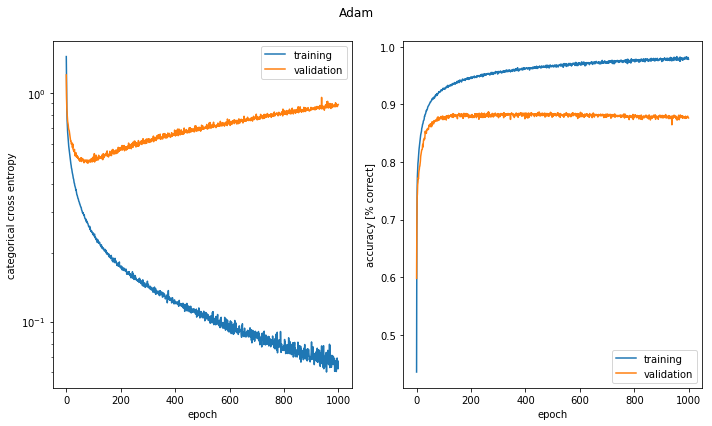

In [18]:
plot_history(adam_history, "Adam")
plt.show()

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [ ]:
hidden_n = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
#hidden_n = [10,50]
accuracy = {}
losses = {}

for params in hidden_n:
    accuracy[params] = []
    losses[params] = []
    for n in range(3):
        ex4_model = Sequential([
        Dense(params, input_shape=(256,)),
        Activation('relu'),
        Dense(5),
        Activation('softmax'),])

        ex4_model.compile(optimizer=SGD(lr=0.1),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        h = ex4_model.fit(x_train, y_train, validation_split=0.2, epochs=50,  batch_size=128, verbose=1)
        accuracy[params].append(h.history.get('val_acc')[-1]) 
        losses[params].append(h.history.get('val_loss')[-1])

In [ ]:
for param in hidden_n:
    plt.figure()
    plt.title('LOSS -- Number of hidden units:{}'.format(param))
    plt.boxplot(losses[params], manage_xticks=True)
    plt.figure()
    plt.title('ACCURACY -- Number of hidden units:{}'.format(param))
    plt.boxplot(accuracy[params], manage_xticks=True)

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution